# LLM Decoder Inference of the Restaurant Reviews

## Download the necessary packages
Recommend using Linux or WSL for Windows.
A good Nvidia GPU (rtx-30xx/40xx) is required for reasonable speed.

In [1]:
!nvidia-smi

Wed May 15 23:37:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:04:00.0 Off |                  Off |
| 30%   33C    P8              25W / 300W |      2MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

The following install the required package for cuda 12.1 in Linux, for the newer RTX 30xx GPUs or higher 

In [ ]:
!python -m pip install --upgrade pip
!python -m pip install --upgrade --force-reinstall --no-cache-dir torch==2.2.0 triton \
  --index-url https://download.pytorch.org/whl/cu121
!python -m pip install "unsloth[cu121-ampere-torch220] @ git+https://github.com/unslothai/unsloth.git"

If installed without failure, starts by downloading the model we are gonna use.

In [2]:
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/llama-3-8b-Instruct-bnb-4bit",
    dtype=None,        # None for auto detect
    load_in_4bit=True,
) # about 6GB in size

/workspace/dpo/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/dpo/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


==((====))==  Unsloth: Fast Llama patching release 2024.4
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.536 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.0+cu121. CUDA = 8.6. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.24. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Acquire Dataset

We will be using the yelp dataset for experimenting

In [3]:
DATASET_SIZE = 960

In [4]:
# Sample Dataset for Testing
from datasets import load_dataset, VerificationMode

dataset = load_dataset("mrcaelumn/yelp_restaurant_review_labelled", data_files={'test':'data/test-00000-of-00002-9007d2596358349d.parquet'}, split=f'test[:{DATASET_SIZE}]', verification_mode=VerificationMode.NO_CHECKS)
dataset.set_format(type="torch")

## Preprocesssing

Now let's set up the function to format the prompt according to LLama 3's specication, as well as tokenizing it.

In [5]:
import torch

categories = ["FOOD", "LOCATION", "ATOMSPHERE", "SERVICE", "PRICE", "MENU", "SPEED"]

def format_prompt(category, review):
    # review = 'The waitress is nice and the food is the best thing i have ever had, it is so good! However, the atomsphere sucks and i hate how loud it is.'

    messages = [
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": f'Rate the following restaurant review in the category of {category} from 1 to 5 where 1 means the worst possible and 5 means the best in their life. Only rate how good the {category} is. Do not pay attention to other factors. If the category {category} is not mentioned in the review, output "NOT MENTIONED" instead. Review: "{review}" '},
        {"role": "assistant", "content": f"The rating of {category} is: "}
    ]
    # The apply_chat_template auto inserts a [eot_id] token at the end, which we will discard.
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
    )[:-10]
    return prompt

def preprocess(batch):
    reviews = batch['text']
    results = {}
    for category in categories:
        prompts = []
        for review in reviews:
            prompts.append(format_prompt(category, review))

        results[category] = prompts
    return results

dataset = dataset.map(preprocess, batched=True, batch_size=256)

Map: 100%|██████████| 960/960 [00:00<00:00, 1360.70 examples/s]


Let's checkout the length distrbution of the review:

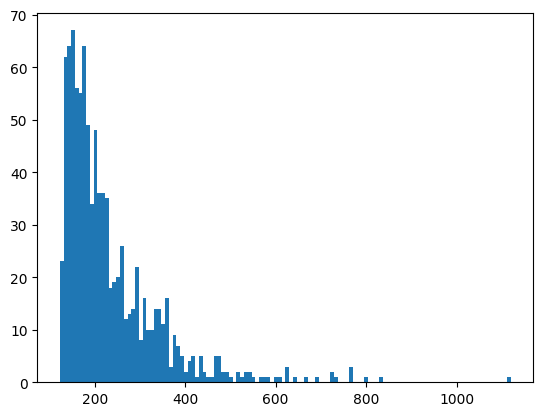

In [6]:
from matplotlib import pyplot as plt
tokens = tokenizer(
    dataset['ATOMSPHERE'],
    return_tensors="pt",
    padding=True
)

input_ids = tokens.input_ids
attention_mask = tokens.attention_mask

token_lengths = torch.sum(attention_mask, dim=-1)

# Plot the distribution of token lengths
plt.hist(token_lengths, bins=120)
plt.show()

In [45]:
token_lengths = token_lengths.to(torch.float32)

print(f"Mean: {torch.mean(token_lengths).item()}")
print(f"Std: {torch.std(token_lengths).item()}")
print(f"95th percentile: {torch.quantile(token_lengths, 0.95).item()}")

Mean: 232.88645935058594
Std: 110.06976318359375
95th percentile: 433.04998779296875


From the histogram, we can see that 95% review has length of less than 424. We will use that as the max length.

In [54]:
MAX_LENGTH = 424
BATCH_SIZE = 32

num_batch = DATASET_SIZE // BATCH_SIZE

Let's batch up the data and send it to GPU before the actual inteference. This should hopefully speed things up because there is now less cpu to gpu communication.

In [55]:
batched_input_ids = {}
batched_attention_masks = {}

for category in categories:
    tokens = tokenizer(
        dataset[category],
        return_tensors="pt",
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

    input_ids = tokens.input_ids.to(model.device)
    attention_mask = tokens.attention_mask.to(model.device)

    input_ids = input_ids.reshape(-1, BATCH_SIZE, MAX_LENGTH)
    attention_mask = attention_mask.reshape(-1, BATCH_SIZE, MAX_LENGTH)

    batched_input_ids[category] = input_ids
    batched_attention_masks[category] = attention_mask

## Inference

We will use the probability output of the model for the last token.

We will record the logits for each of the rating number, as well as the probability of the model saying "NOT".

Let the logits for rating number $i$ be $l_i$, the score can be cacluated as

$$s = \frac{\sum_{i=1}^5 i \exp(l_i)}{\sum_{i=1}^5 \exp(l_i)}$$
for that category.

If the probablity of the model saying "NOT" is very high, that means the model thinks the category is not mentioned in the review. In that case we should discard the rating.

In particular, denote the logits for predicting NOT as $l_n$, we can extract a "usefulness" parameter $u$

$$u = \frac{\sum_{i=1}^5 \exp(l_i)}{exp(l_n) + \sum_{i=1}^5 \exp(l_i)}$$

In [56]:
from tqdm import trange # progress bar

# llama 3 stores digit id as 15 + that digit
numbers = torch.tensor([1,2,3,4,5]).to(model.device)
indices = numbers + 15

# the id for the word "NOT" is 14394
# If the model has a high probability of predicting this word, it means the review score is not going to be useful
not_id = 14394

review_scores = torch.zeros(len(categories), len(dataset))
review_usefulness= torch.zeros(len(categories), len(dataset))

def tokenize(prmopts):
    inputs = tokenizer(
        prmopts,
        max_length=MAX_LENGTH,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )
    return inputs

with torch.no_grad():
    for i, category in enumerate(categories):
        for j in trange(num_batch):
            input_ids = batched_input_ids[category][j]
            attention_mask = batched_attention_masks[category][j]
            # get the logits for the 5 number we are interested in
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=False,
                use_cache=False
                ).logits[:, -1]

            number_logits = logits[:, indices]
            exp_logits = torch.exp(number_logits)
            exp_logits_sum = torch.sum(exp_logits, dim=1)

            not_logits = logits[:, not_id]
            exp_not_logits = torch.exp(not_logits)

            review_usefulness[i, j*BATCH_SIZE:(j+1)*BATCH_SIZE] = exp_logits_sum / (exp_not_logits + exp_logits_sum)

            scores = torch.sum(exp_logits * numbers, dim=1) / exp_logits_sum
            review_scores[i, j*BATCH_SIZE:(j+1)*BATCH_SIZE] = scores

100%|██████████| 30/30 [00:59<00:00,  1.98s/it]


## Analyze

Let's plot the review usefulness to see just how much review can we consider as useful.

[]

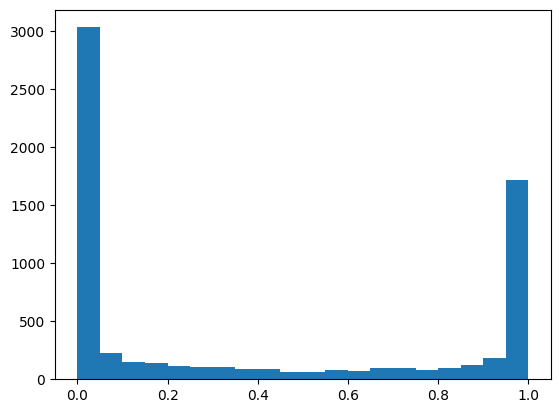

In [76]:
usefulness = review_usefulness[:, ].flatten().cpu().numpy()

plt.hist(usefulness, bins=20)
plt.plot()

Sadly the model thinks that 2/3 of the reviews is not helpful. This is to be expected because a normal review won't cover all the categories.

Let's choose a usefulness threshold of 0.5 for the mask.

FOOD: 296 out of 960 reviews are ignored
LOCATION: 760 out of 960 reviews are ignored
ATOMSPHERE: 585 out of 960 reviews are ignored
SERVICE: 349 out of 960 reviews are ignored
PRICE: 755 out of 960 reviews are ignored
MENU: 632 out of 960 reviews are ignored
SPEED: 742 out of 960 reviews are ignored


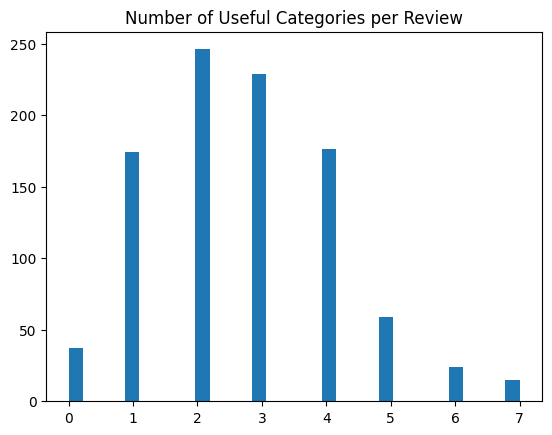

In [68]:
review_mask = review_usefulness > 0.5

# let's see how much responses we are ignoring
for i, category in enumerate(categories):
    print(f"{category}: {num_batch*BATCH_SIZE - torch.sum(review_mask[i]).item()} out of {num_batch*BATCH_SIZE} reviews are ignored")

# let's also see how much useful category does each review have
useful_reviews = torch.sum(review_mask[:, :num_batch*BATCH_SIZE], dim=0)
plt.hist(useful_reviews, bins=32)
plt.title("Number of Useful Categories per Review")
plt.show()

Let's insepct somes reviews that are relevant to the location. Just to make sure they are correct.

In [85]:
location_id = categories.index("LOCATION")
index = torch.nonzero(review_mask[location_id] == True)

# let's see some of the reviews that are useful for location
for i in range(10):
    print(dataset['text'][index[i].item()])

Ate here during my stay in French Quarters. Loved it. It was literally the first thing I a right off the plane because of its
Proximity to the hotel. Whoever suggested to eat there during the day was absolutely right. Because it's right on Bourbon St, it gets busy and the line is well over a 20 minute wait. We were able to walk right in. Even if it's a line, the staff works with all different party sizes to get you in and eating as soon as possible. The staff are real locals and that made me comfortable. Not sure how that's a bad thing. Again this is a comfort restaurant. Food was a bit pricey but certainly worth it. Hands down...best Oysters you'll find out here.
Came in from Texas for vacation. Wanted something genuine to Tennessee and this place was recommended in passing. Parking situation was not great but that seems to be a problem all around town. Waited in line for 25-30 min but really wanted to try this place. Food was worth it! The chicken itself was delicious and I'm not eve

Most of these reviews have mentioned something about the location, which means the model behaves as expected.

In [69]:
actual_scores = dataset['label']

actual_scores.shape

torch.Size([960])

In [71]:
review_scores.shape, review_mask.shape

(torch.Size([7, 960]), torch.Size([7, 960]))

For each category, let's calculate the spearmanr and pearsonr corrleation to see how relevant they are. We will only consider the reviews that is useful to that category.

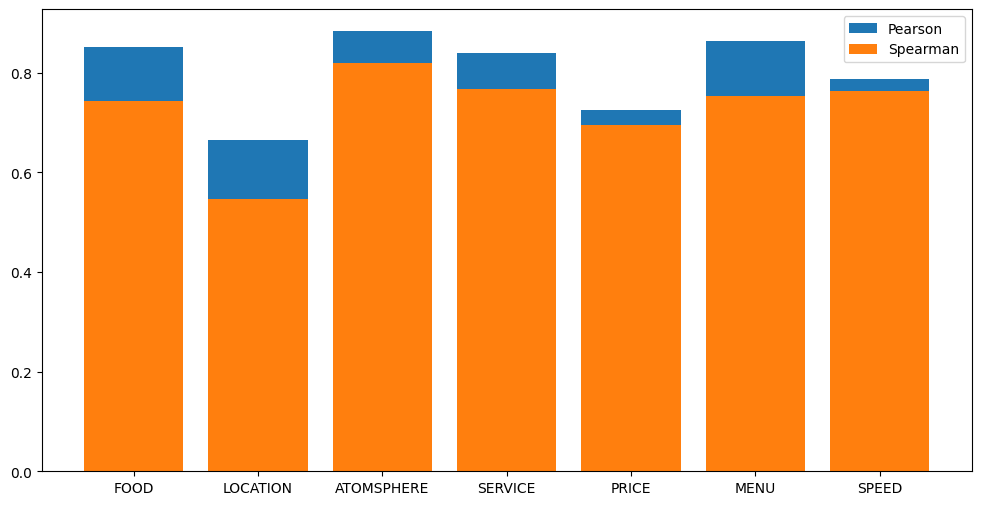

In [75]:
# spearsman and pearson correlation
from scipy.stats import spearmanr, pearsonr

spearmans = []
pearsons = []
for i, category in enumerate(categories):
    mask = review_mask[i]
    predicated_scores = review_scores[i][mask].cpu()
    real_scores = actual_scores[mask]
    spearman = spearmanr(predicated_scores, real_scores.cpu())
    pearson = pearsonr(predicated_scores, real_scores.cpu())
    spearmans.append(spearman)
    pearsons.append(pearson)

fig = plt.figure(figsize=(12, 6))

plt.bar(categories, [pearson[0] for pearson in pearsons], label='Pearson')
plt.bar(categories, [spearman.correlation for spearman in spearmans], label='Spearman')

plt.legend()
plt.show()